In [13]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.amp import autocast, GradScaler

# Enable cuDNN benchmark for faster training
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
data_dir = os.path.join("9layerplantdatacnn", "data", "noaug", "noaug data")
batch_size = 64  # Increased batch size
img_size = 224  # ConvNeXt uses 224x224

# Training transforms with simpler augmentation for speed
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=train_transform)
class_names = dataset.classes
num_classes = len(class_names)

print(f"Dataset loaded with {len(dataset)} images across {num_classes} classes")
print("Classes:", class_names)

# Create train/validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update validation dataset transform
val_dataset.dataset.transform = val_transform

# Create optimized data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size*2,  # Larger batch size for validation
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

Dataset loaded with 55448 images across 39 classes
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite

In [16]:
# Initialize model with updated API
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)

# Load previously saved weights if continuing training
model_path = "plant_disease_convnext.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("✅ Loaded model from checkpoint.")
else:
    print("⚠️ No checkpoint found. Training from scratch.")

# Set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

⚠️ No checkpoint found. Training from scratch.


C:\Users\aakas\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Add this cell to check CUDA status
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")
    
    # Check if model is on CUDA
    print(f"Model is on CUDA: {next(model.parameters()).is_cuda}")
    
    # Check CUDA memory usage
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"CUDA memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4070 Laptop GPU
Model is on CUDA: True
CUDA memory allocated: 4.34 GB
CUDA memory cached: 8.50 GB


In [21]:
# Add this cell to profile your training
import time

# Test batch processing speed
model.train()
start_time = time.time()
num_batches = 0

with torch.cuda.amp.autocast():
    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(images)
        num_batches += 1
        if num_batches >= 10:  # Process 10 batches for timing
            break

end_time = time.time()
print(f"Time per batch: {(end_time - start_time) / num_batches:.3f} seconds")
print(f"Images per second: {(num_batches * batch_size) / (end_time - start_time):.1f}")

C:\Users\aakas\AppData\Local\Temp\ipykernel_31904\99324422.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Time per batch: 0.373 seconds
Images per second: 171.6


In [25]:
# Editable param: number of epochs per run
num_epochs = 1

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Initialize gradient scaler for mixed precision
scaler = GradScaler()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        # Move data to GPU with non-blocking transfer
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        # Forward pass with mixed precision
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)
    
    # Store training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Forward pass with mixed precision
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Track metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    # Store validation metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

Epoch 1/1:  13%|█▎        | 91/694 [00:23<02:33,  3.93it/s, acc=99.9, loss=0.000112]


KeyboardInterrupt: 

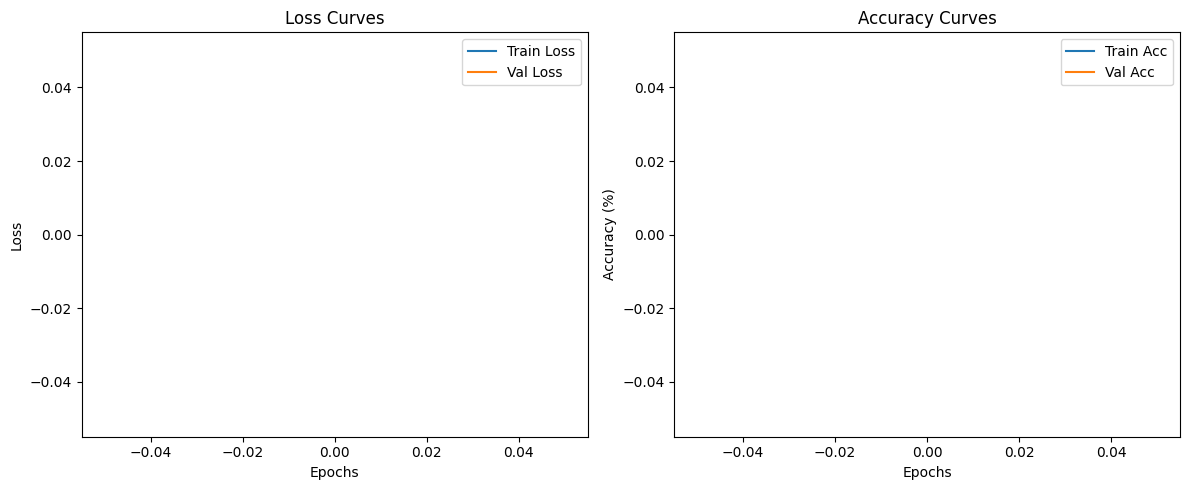

In [26]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
torch.save(model.state_dict(), "plant_disease_convnext.pth")
print("💾 Model saved.")

💾 Model saved.


Selected image: 9layerplantdatacnn\data\noaug\noaug data\Orange___Haunglongbing_(Citrus_greening)\image (4210).JPG
True class: Orange___Haunglongbing_(Citrus_greening)


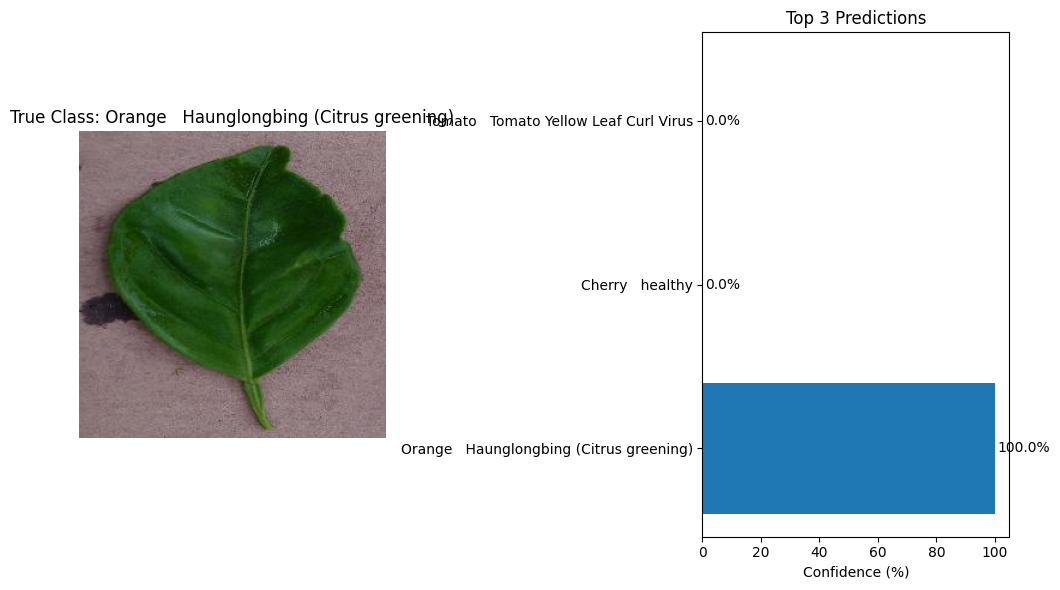

✅ CORRECT: Model predicted Orange   Haunglongbing (Citrus greening) with 100.0% confidence


In [35]:
# Cell for testing the model with a random image
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

def test_random_image():
    # Load the trained model
    model_path = "plant_disease_convnext.pth"
    if not os.path.exists(model_path):
        print("❌ Model file not found. Please train the model first.")
        return
    
    # Initialize model architecture
    model = models.convnext_tiny(weights=None)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    
    # Load weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Setup image transformation (same as validation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Choose a random image from the dataset
    data_path = os.path.join("9layerplantdatacnn", "data", "noaug", "noaug data")
    all_classes = os.listdir(data_path)
    
    # Filter out any non-directory items
    all_classes = [cls for cls in all_classes if os.path.isdir(os.path.join(data_path, cls))]
    
    # Choose a random class
    random_class = random.choice(all_classes)
    class_path = os.path.join(data_path, random_class)
    
    # Get all images in the class folder (case-insensitive extension check)
    image_files = []
    for f in os.listdir(class_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            image_files.append(f)
    
    if not image_files:
        print(f"❌ No images found in {class_path}")
        return
    
    # Select a random image
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)
    print(f"Selected image: {image_path}")
    print(f"True class: {random_class}")
    
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    
    # Get top 3 predictions
    top3_prob, top3_indices = torch.topk(probabilities, 3)
    top3_prob = top3_prob.cpu().numpy()
    top3_indices = top3_indices.cpu().numpy()
    
    # Display results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"True Class: {random_class.replace('_', ' ')}")
    plt.axis('off')
    
    # Plot predictions
    plt.subplot(1, 2, 2)
    y_pos = np.arange(3)
    top3_classes = [class_names[i] for i in top3_indices]
    top3_classes_display = [c.replace('_', ' ') for c in top3_classes]
    
    bars = plt.barh(y_pos, top3_prob * 100, align='center')
    plt.yticks(y_pos, top3_classes_display)
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'{top3_prob[i]*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction result
    predicted_class = class_names[top3_indices[0]]
    confidence = top3_prob[0] * 100
    
    if predicted_class == random_class:
        result = "✅ CORRECT"
    else:
        result = "❌ INCORRECT"
    
    print(f"{result}: Model predicted {predicted_class.replace('_', ' ')} with {confidence:.1f}% confidence")

# Run the test
test_random_image()

Testing on augmented data from: 9layerplantdatacnn\data\aug\aug data
Selected image: 9layerplantdatacnn\data\aug\aug data\Pepper,_bell___healthy\image (1044).JPG
True class: Pepper,_bell___healthy


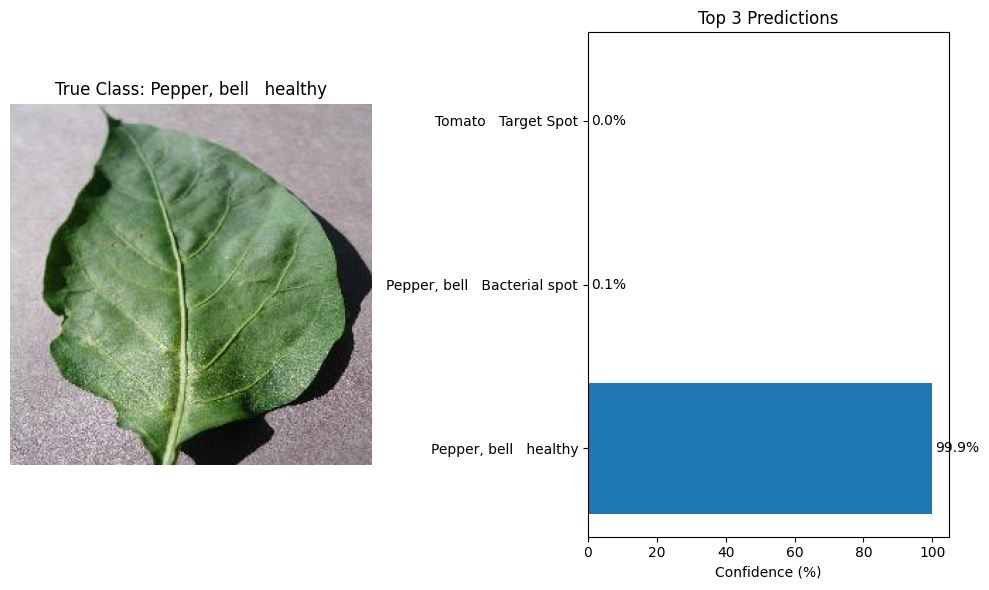

✅ CORRECT: Model predicted Pepper, bell   healthy with 99.9% confidence


In [37]:
# Cell for testing the model with augmented data
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

def test_augmented_image():
    # Load the trained model
    model_path = "plant_disease_convnext.pth"
    if not os.path.exists(model_path):
        print("❌ Model file not found. Please train the model first.")
        return
    
    # Initialize model architecture
    model = models.convnext_tiny(weights=None)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    
    # Load weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Setup image transformation (same as validation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Choose a random image from the AUGMENTED dataset
    data_path = os.path.join("9layerplantdatacnn", "data", "aug", "aug data")
    print(f"Testing on augmented data from: {data_path}")
    
    all_classes = os.listdir(data_path)
    
    # Filter out any non-directory items
    all_classes = [cls for cls in all_classes if os.path.isdir(os.path.join(data_path, cls))]
    
    # Choose a random class
    random_class = random.choice(all_classes)
    class_path = os.path.join(data_path, random_class)
    
    # Get all images in the class folder (case-insensitive extension check)
    image_files = []
    for f in os.listdir(class_path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            image_files.append(f)
    
    if not image_files:
        print(f"❌ No images found in {class_path}")
        return
    
    # Select a random image
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)
    print(f"Selected image: {image_path}")
    print(f"True class: {random_class}")
    
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    
    # Get top 3 predictions
    top3_prob, top3_indices = torch.topk(probabilities, 3)
    top3_prob = top3_prob.cpu().numpy()
    top3_indices = top3_indices.cpu().numpy()
    
    # Display results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"True Class: {random_class.replace('_', ' ')}")
    plt.axis('off')
    
    # Plot predictions
    plt.subplot(1, 2, 2)
    y_pos = np.arange(3)
    top3_classes = [class_names[i] for i in top3_indices]
    top3_classes_display = [c.replace('_', ' ') for c in top3_classes]
    
    bars = plt.barh(y_pos, top3_prob * 100, align='center')
    plt.yticks(y_pos, top3_classes_display)
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'{top3_prob[i]*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction result
    predicted_class = class_names[top3_indices[0]]
    confidence = top3_prob[0] * 100
    
    if predicted_class == random_class:
        result = "✅ CORRECT"
    else:
        result = "❌ INCORRECT"
    
    print(f"{result}: Model predicted {predicted_class.replace('_', ' ')} with {confidence:.1f}% confidence")

# Run the test
test_augmented_image()

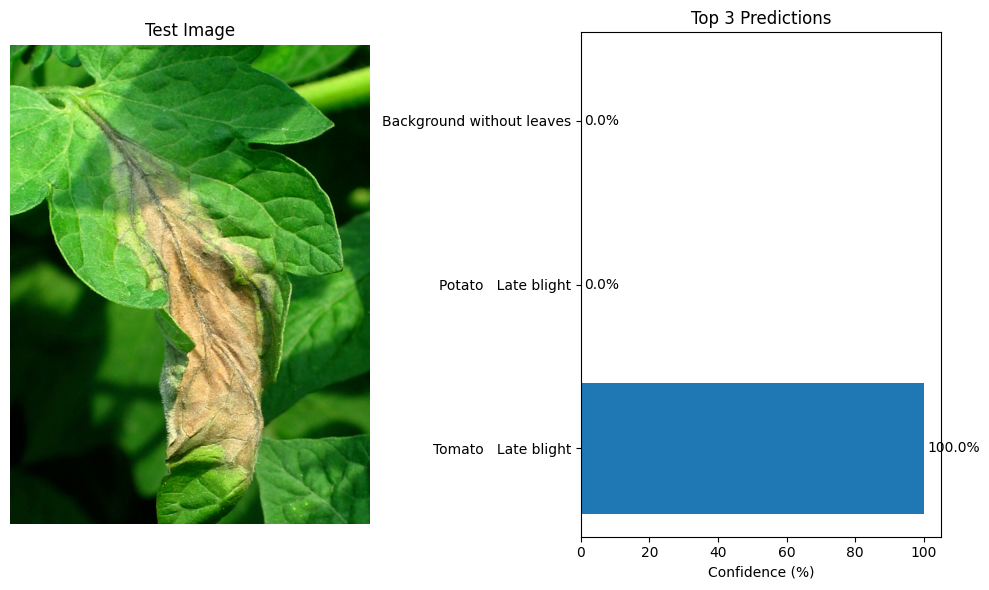

Top prediction: Tomato   Late blight with 100.0% confidence


: 

In [ ]:
# Cell for testing the model with both URLs and local images
import os
import requests
from io import BytesIO
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def test_image(image_source):
    """
    Test the model on an image from a URL or local file
    
    Args:
        image_source: URL or local file path to the image
    """
    # Load the trained model
    model_path = "plant_disease_convnext.pth"
    if not os.path.exists(model_path):
        print("❌ Model file not found. Please train the model first.")
        return
    
    # Initialize model architecture
    model = models.convnext_tiny(weights=None)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    
    # Load weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Setup image transformation (same as validation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    try:
        # Check if the input is a URL or a local file path
        if image_source.startswith(('http://', 'https://')):
            print(f"Downloading image from URL: {image_source}")
            response = requests.get(image_source, timeout=10)
            response.raise_for_status()  # Raise an exception for HTTP errors
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Treat as local file path
            if not os.path.exists(image_source):
                print(f"❌ Local file not found: {image_source}")
                return
            print(f"Loading image from local path: {image_source}")
            image = Image.open(image_source).convert('RGB')
        
        # Process the image
        input_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda'):
                output = model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        
        # Get top 3 predictions
        top3_prob, top3_indices = torch.topk(probabilities, 3)
        top3_prob = top3_prob.cpu().numpy()
        top3_indices = top3_indices.cpu().numpy()
        
        # Display results
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Test Image")
        plt.axis('off')
        
        # Plot predictions
        plt.subplot(1, 2, 2)
        y_pos = np.arange(3)
        top3_classes = [class_names[i] for i in top3_indices]
        top3_classes_display = [c.replace('_', ' ') for c in top3_classes]
        
        bars = plt.barh(y_pos, top3_prob * 100, align='center')
        plt.yticks(y_pos, top3_classes_display)
        plt.xlabel('Confidence (%)')
        plt.title('Top 3 Predictions')
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{top3_prob[i]*100:.1f}%', va='center')
        
        plt.tight_layout()
        plt.show()
        
        # Print prediction result
        predicted_class = class_names[top3_indices[0]]
        confidence = top3_prob[0] * 100
        
        print(f"Top prediction: {predicted_class.replace('_', ' ')} with {confidence:.1f}% confidence")
                
    except Exception as e:
        print(f"Error processing image: {str(e)}")

# Example usage - you can run this with either a URL or local file path
image_source = input("Enter image URL or local file path: ")
test_image(image_source)